In [1]:
import os
import csv
import pandas as pd
import time
import pickle
import sys


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# train test split, linear regression, ridge regression, lasso regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
print(os.getcwd())
# cwd = os.chdir(os.path.join(os.getcwd(), "logda"))

/Users/pedram/Projects/DaTu/ML/logda


In [4]:
#File_xlsx = "data/integration_log_group_a.xlsx"
#File_score_xlsx = "data/Groupa_scores.xlsx"


File_xlsx = "data/integration_log_group_b.xlsx"
File_score_xlsx = "data/Groupb_scores.xlsx"

df = pd.read_excel(File_xlsx)
df = df.iloc[:, :-1] 

print(df.head())

  username           Date and Time Time since session started\n(h:mm:ss)  \
0       b1 2023-08-22 09:40:01.507                              00:00:00   
1       b1 2023-08-22 09:40:04.325                              00:00:02   
2       b1 2023-08-22 09:42:26.628                              00:02:25   
3       b1 2023-08-22 09:43:16.373                              00:03:14   
4       b1 2023-08-22 09:43:16.373                              00:03:14   

         space                     action  
0          NaN                 User login  
1   /courses/1                  Load page  
2  EDA Toolbox  Load default toolbox page  
3    Problem 1              Start problem  
4    Problem 1         Request first hint  


In [5]:
# get the unique values of the column action
unique_actions = df.action.unique()
# peint unique actions with their counts
print(df['action'].value_counts())

action
Change answer                      7007
First answer                       2410
Update confidence                  1660
Request another hint               1233
New answer explanation             1131
Streamlit interaction              1113
Update answer explanation          1025
Paste answer                       1016
Request first hint                  874
Auto-save log                       856
Load page                           853
Freeform code run                   817
Load default toolbox page           634
Run code error                      348
Start reading sub-module            313
Run code                            263
Respond to hint feedback            219
Start problem                       129
Submit problem                      124
Complete sub-module                  80
User login                           58
Save note                            34
Stop reading sub-module preview      14
User logout                           3
Name: count, dtype: int64


In [6]:
# since the frequency of different actions are different, Normalize the counts of actions by the total number of actions per user to account for the difference in frequencies.

# create new df where the rows are each user and the columns are the counts of each action from unique_actions
action_counts = pd.DataFrame(columns=unique_actions)
for user in df.username.unique():
    user_actions = df[df.username == user].action.value_counts()
    action_counts.loc[user, user_actions.index] = user_actions.values
action_counts = action_counts.fillna(0)
# add the total_actions column to the action_counts df
action_counts['total'] = df.groupby('username').count().action
flag = 0
action_counts.head()

,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,Respond to hint feedback,Submit problem,Paste answer,Freeform code run,Save note,Start reading sub-module,User logout,Complete sub-module,Stop reading sub-module preview,total
b1,1,4,66,3,33,68,39,34,63,373,...,2,3,63,98,0,0,0,0,0,1014
b2,3,13,24,3,10,61,80,39,0,248,...,4,3,19,19,10,1,0,0,0,701
b3,2,3,5,3,23,49,52,21,38,268,...,6,3,36,43,0,0,0,0,0,599
b6,1,7,9,3,35,62,43,12,30,160,...,2,3,8,7,0,0,0,0,0,426
b7,1,8,8,3,26,71,58,52,31,179,...,5,3,13,25,3,0,0,0,0,611


In [7]:
# read the scores
read_file = pd.read_excel(File_score_xlsx)

# change the first column name to username
read_file.rename(columns={"Participant ID's":'username', 'Problem 1 (Score out of 16)': 'score1',
                         'Problem 2 (Score out of 20)': 'score2', 'Problem 3 (Score out of 18)': 'score3' }, inplace=True)
read_file[:-3]
# use the username as the index
read_file.set_index('username', inplace=True)
# devide first column by 16, second column by 20, third column by 18
read_file['score1'] = read_file['score1'].div(16)
read_file['score2'] = read_file['score2'].div(20)
read_file['score3'] = read_file['score3'].div(18)

read_file.head()


,score1,score2,score3
username,,,
b1,0.8750,0.65,0.833333
b2,0.6875,0.50,0.722222
b3,0.8125,0.45,1.000000
b6,0.6250,0.30,0.277778
b7,0.5000,0.45,0.833333


In [8]:
# merge the scores with the action_counts df
if not flag:
    action_counts = action_counts.merge(read_file, left_index=True, right_index=True)
flag = 1
action_counts.head()


,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,Freeform code run,Save note,Start reading sub-module,User logout,Complete sub-module,Stop reading sub-module preview,total,score1,score2,score3
b1,1,4,66,3,33,68,39,34,63,373,...,98,0,0,0,0,0,1014,0.8750,0.65,0.833333
b2,3,13,24,3,10,61,80,39,0,248,...,19,10,1,0,0,0,701,0.6875,0.50,0.722222
b3,2,3,5,3,23,49,52,21,38,268,...,43,0,0,0,0,0,599,0.8125,0.45,1.000000
b6,1,7,9,3,35,62,43,12,30,160,...,7,0,0,0,0,0,426,0.6250,0.30,0.277778
b7,1,8,8,3,26,71,58,52,31,179,...,25,3,0,0,0,0,611,0.5000,0.45,0.833333


In [9]:
# create a score colomn by averaging the three scores
action_counts['score'] = action_counts[['score1', 'score2', 'score3']].mean(axis=1)

In [10]:
df = df.fillna('0')
df.iloc[0, 3] = 'Probelm 1'
# change the third column name to time
df.rename(columns={"Time since session started\n(h:mm:ss)":'time'}, inplace=True)
df.head()

,username,Date and Time,time,space,action
0,b1,2023-08-22 09:40:01.507,00:00:00,Probelm 1,User login
1,b1,2023-08-22 09:40:04.325,00:00:02,/courses/1,Load page
2,b1,2023-08-22 09:42:26.628,00:02:25,EDA Toolbox,Load default toolbox page
3,b1,2023-08-22 09:43:16.373,00:03:14,Problem 1,Start problem
4,b1,2023-08-22 09:43:16.373,00:03:14,Problem 1,Request first hint


In [11]:
# correct the df. If in the space column does not start with 'Problem' then change it with the next row
for i in range(len(df)):
    if df.iloc[i, 3][:7] != 'Problem':
        df.iloc[i, 3] = df.iloc[i-1, 3]

In [12]:
df['space'].value_counts()

space
Problem 1     7958
Problem 3     7505
Problem 2     6748
/courses/1       3
Name: count, dtype: int64

In [13]:
# let's create a new df where the colomns are the count of actions for each problem plus the problem number, username and the corresponding score
new_df = pd.DataFrame(columns= list(unique_actions)+ [ 'total_actions']+ [p for p in df.space.unique()]+ ['username', 'score']) 
for user in df.username.unique():
    if user == 'b27':
            continue
    for problem in df.space.unique():
        user_problem = df[(df.username == user) & (df.space == problem)].action.value_counts()
        new_df.loc[len(new_df), user_problem.index] = user_problem.values
        new_df.loc[len(new_df)-1, str(problem)] = 1
        new_df.loc[len(new_df)-1, 'username'] = (user,str(problem)[-1:])
        new_df.loc[len(new_df)-1, 'score'] = action_counts.loc[user, 'score'+str(problem)[-1:]]
        new_df.loc[len(new_df)-1, 'total_actions'] = action_counts.loc[user, 'total']
new_df = new_df.fillna(0)
new_df.head()

,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,User logout,Complete sub-module,Stop reading sub-module preview,total_actions,/courses/1,Problem 1,Problem 2,Problem 3,username,score
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1014,1,0,0,0,"(b1, 1)",0.875000
1,0,0,25,1,9,16,8,15,15,140,...,0,0,0,1014,0,1,0,0,"(b1, 1)",0.875000
2,0,1,29,1,11,41,17,17,22,72,...,0,0,0,1014,0,0,1,0,"(b1, 2)",0.650000
3,0,2,11,1,13,11,14,2,26,161,...,0,0,0,1014,0,0,0,1,"(b1, 3)",0.833333
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,701,1,0,0,0,"(b2, 1)",0.687500


## Feature engineering

In [14]:
# feaure engineeging:
# 1. average time between certain actions (e.g. average time between ‘First answer’ and ‘Change answer’ actions)
# 2. ratio of ‘Change answer’ actions to ‘First answer’ actions (A high ratio could indicate that the user often changes their first answer)
# 3. Action Sequences: capture order of actions. whether ‘Request another hint’ often follows ‘First answer’.

In [15]:
# check for type(df.iloc[i, 2]) if is not datetime.time, then convert it to datetime.time
import datetime
for i in range(len(df)):
    if type(df.iloc[i, 2]) != datetime.time:
        df.iloc[i, 2] = df.iloc[i, 2].time()

In [16]:
# add a new feature called elapsed time that is difference between the time column of df for 'Start problem' and 'Submit problem' as actions 
# if no 'submit problem' action then the elapsed time is zero

new_df['elapsed_time'] = float('nan')
record = 0 # time, space, username
for i in range(len(df)):
    if df.iloc[i, 4] == 'Start problem':
        if record:
            new_df.loc[new_df.username == (record[2], record[1][-1:]), 'elapsed_time'] = float('nan')
            others = record
        record = [df.iloc[i, 2], df.iloc[i, 3], df.iloc[i, 0]] # time, space, username
    elif df.iloc[i, 4] == 'Submit problem':
        if not record:
            print('Error: no start problem for username: ', df.iloc[i, 0], ' and : ', df.iloc[i, 3])
        elif df.iloc[i, 3] == record[1] and df.iloc[i, 0] == record[2]:
            
            new_df.loc[new_df.username == (record[2], record[1][-1:]), 'elapsed_time'] = (datetime.datetime.combine(datetime.datetime.today(), df.iloc[i, 2])
                                                                                       - datetime.datetime.combine(datetime.datetime.today(), record[0])).total_seconds()
            
        else:
            if others and df.iloc[i, 3] == others[1] and df.iloc[i, 0] == others[2]:
                print('found a match for', others)
                new_df.loc[new_df.username == (others[2], others[1][-1:]), 'elapsed_time'] = (datetime.datetime.combine(datetime.datetime.today(), df.iloc[i, 2])
            - datetime.datetime.combine(datetime.datetime.today(), others[0])).total_seconds()
                others = 0
            else:
                print('Mismatch: for username: ', df.iloc[i, 0], ' and ', df.iloc[i, 3], 'current record: ', record)
        record = 0
new_df

found a match for [datetime.time(0, 59, 3), 'Problem 2', 'b43']
Error: no start problem for username:  b43  and :  Problem 3


,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,Complete sub-module,Stop reading sub-module preview,total_actions,/courses/1,Problem 1,Problem 2,Problem 3,username,score,elapsed_time
0,1,1,1,0,0,0,0,0,0,0,...,0,0,1014,1,0,0,0,"(b1, 1)",0.875000,8382.0
1,0,0,25,1,9,16,8,15,15,140,...,0,0,1014,0,1,0,0,"(b1, 1)",0.875000,8382.0
2,0,1,29,1,11,41,17,17,22,72,...,0,0,1014,0,0,1,0,"(b1, 2)",0.650000,3690.0
3,0,2,11,1,13,11,14,2,26,161,...,0,0,1014,0,0,0,1,"(b1, 3)",0.833333,16772.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,701,1,0,0,0,"(b2, 1)",0.687500,5103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,2,2,3,1,16,13,20,17,31,85,...,0,0,629,0,0,0,1,"(b49, 3)",0.472222,2150.0
172,0,0,0,0,0,0,0,0,0,0,...,0,0,515,1,0,0,0,"(b51, 1)",0.375000,6534.0
173,0,3,5,1,15,16,25,17,20,20,...,0,0,515,0,1,0,0,"(b51, 1)",0.375000,6534.0
174,0,1,2,1,19,48,22,20,22,52,...,0,0,515,0,0,1,0,"(b51, 2)",0.400000,1407.0


In [17]:
# create new appropiate score with one decimal
new_df['tmp'] = new_df['score'].round(1)
# impute the nan values with the mean of the elapsed time with the round up score with one decimal
new_df['elapsed_time'] = new_df.groupby('tmp')['elapsed_time'].transform(lambda x: x.fillna(x.mean()))
new_df = new_df.drop('tmp', axis=1)
new_df

,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,Complete sub-module,Stop reading sub-module preview,total_actions,/courses/1,Problem 1,Problem 2,Problem 3,username,score,elapsed_time
0,1,1,1,0,0,0,0,0,0,0,...,0,0,1014,1,0,0,0,"(b1, 1)",0.875000,8382.0
1,0,0,25,1,9,16,8,15,15,140,...,0,0,1014,0,1,0,0,"(b1, 1)",0.875000,8382.0
2,0,1,29,1,11,41,17,17,22,72,...,0,0,1014,0,0,1,0,"(b1, 2)",0.650000,3690.0
3,0,2,11,1,13,11,14,2,26,161,...,0,0,1014,0,0,0,1,"(b1, 3)",0.833333,16772.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,701,1,0,0,0,"(b2, 1)",0.687500,5103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,2,2,3,1,16,13,20,17,31,85,...,0,0,629,0,0,0,1,"(b49, 3)",0.472222,2150.0
172,0,0,0,0,0,0,0,0,0,0,...,0,0,515,1,0,0,0,"(b51, 1)",0.375000,6534.0
173,0,3,5,1,15,16,25,17,20,20,...,0,0,515,0,1,0,0,"(b51, 1)",0.375000,6534.0
174,0,1,2,1,19,48,22,20,22,52,...,0,0,515,0,0,1,0,"(b51, 2)",0.400000,1407.0


In [18]:
# find average time on 'streamlit intraction', 'request hint', 'New answer explanation','free from code run', difference in 
# 'start reading submodule' to 'stop reading submodule', 'user request' for chatbot


In [19]:
# find sum time on 'streamlit intraction' by subtracting it's time to the next action other than 'streamlit intraction' or 'load defualt toolbox page'
new_df['streamlit_time'] = 0
itr = 0
while itr < len(df):
    if df.iloc[itr, 4] == 'Streamlit interaction':
        while df.iloc[itr+1, 4] == 'Streamlit interaction' or df.iloc[itr+1, 4] == 'Load default toolbox page':
            itr += 1
        else:
            new_df.loc[new_df.username == (df.iloc[itr, 0], df.iloc[itr,3][-1]), 'streamlit_time'] += (datetime.datetime.combine(datetime.datetime.today(), df.iloc[itr+1, 2])
            - datetime.datetime.combine(datetime.datetime.today(), df.iloc[itr, 2])).total_seconds()
            itr += 1
    else:
        itr += 1

new_df.head()

,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,Stop reading sub-module preview,total_actions,/courses/1,Problem 1,Problem 2,Problem 3,username,score,elapsed_time,streamlit_time
0,1,1,1,0,0,0,0,0,0,0,...,0,1014,1,0,0,0,"(b1, 1)",0.875000,8382.0,581
1,0,0,25,1,9,16,8,15,15,140,...,0,1014,0,1,0,0,"(b1, 1)",0.875000,8382.0,581
2,0,1,29,1,11,41,17,17,22,72,...,0,1014,0,0,1,0,"(b1, 2)",0.650000,3690.0,52
3,0,2,11,1,13,11,14,2,26,161,...,0,1014,0,0,0,1,"(b1, 3)",0.833333,16772.0,72
4,0,0,0,0,0,0,0,0,0,0,...,0,701,1,0,0,0,"(b2, 1)",0.687500,5103.0,609


In [20]:
# find sum time on 'request hint' by subtracting it's time to the next action other than "request hint"
new_df['hint_time'] = 0
itr = 0
while itr < len(df):
    if df.iloc[itr, 4][:7] == 'Request':
        while df.iloc[itr+1, 4][:7] == 'Request':
            itr += 1
        else:
            new_df.loc[new_df.username == (df.iloc[itr, 0], df.iloc[itr,3][-1]), 'hint_time'] += (datetime.datetime.combine(datetime.datetime.today(), df.iloc[itr+1, 2])
            - datetime.datetime.combine(datetime.datetime.today(), df.iloc[itr, 2])).total_seconds()
            itr += 1
    else:
        itr += 1
new_df.head()

,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,total_actions,/courses/1,Problem 1,Problem 2,Problem 3,username,score,elapsed_time,streamlit_time,hint_time
0,1,1,1,0,0,0,0,0,0,0,...,1014,1,0,0,0,"(b1, 1)",0.875000,8382.0,581,978
1,0,0,25,1,9,16,8,15,15,140,...,1014,0,1,0,0,"(b1, 1)",0.875000,8382.0,581,978
2,0,1,29,1,11,41,17,17,22,72,...,1014,0,0,1,0,"(b1, 2)",0.650000,3690.0,52,520
3,0,2,11,1,13,11,14,2,26,161,...,1014,0,0,0,1,"(b1, 3)",0.833333,16772.0,72,10286
4,0,0,0,0,0,0,0,0,0,0,...,701,1,0,0,0,"(b2, 1)",0.687500,5103.0,609,505


In [21]:
# find sum time on 'New answer explanation'
new_df['explain_time'] = 0
itr = 0
while itr < len(df):
    if df.iloc[itr, 4] == 'New answer explanation':
        new_df.loc[new_df.username == (df.iloc[itr, 0], df.iloc[itr,3][-1]), 'explain_time'] += (datetime.datetime.combine(datetime.datetime.today(), df.iloc[itr+1, 2])
            - datetime.datetime.combine(datetime.datetime.today(), df.iloc[itr, 2])).total_seconds()
        itr += 1
    else:
        itr += 1
new_df.head()

,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,/courses/1,Problem 1,Problem 2,Problem 3,username,score,elapsed_time,streamlit_time,hint_time,explain_time
0,1,1,1,0,0,0,0,0,0,0,...,1,0,0,0,"(b1, 1)",0.875000,8382.0,581,978,460
1,0,0,25,1,9,16,8,15,15,140,...,0,1,0,0,"(b1, 1)",0.875000,8382.0,581,978,460
2,0,1,29,1,11,41,17,17,22,72,...,0,0,1,0,"(b1, 2)",0.650000,3690.0,52,520,326
3,0,2,11,1,13,11,14,2,26,161,...,0,0,0,1,"(b1, 3)",0.833333,16772.0,72,10286,3
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,"(b2, 1)",0.687500,5103.0,609,505,217


In [22]:
# find sum time on 'Freeform code run'
new_df['code_time'] = 0
itr = 0
while itr < len(df):
    if df.iloc[itr, 4] == 'Freeform code run':
        new_df.loc[new_df.username == (df.iloc[itr, 0], df.iloc[itr,3][-1]), 'code_time'] += (datetime.datetime.combine(datetime.datetime.today(), df.iloc[itr+1, 2])
            - datetime.datetime.combine(datetime.datetime.today(), df.iloc[itr, 2])).total_seconds()
        itr += 1
    else:
        itr += 1
new_df.head()

,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,Problem 1,Problem 2,Problem 3,username,score,elapsed_time,streamlit_time,hint_time,explain_time,code_time
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,"(b1, 1)",0.875000,8382.0,581,978,460,0
1,0,0,25,1,9,16,8,15,15,140,...,1,0,0,"(b1, 1)",0.875000,8382.0,581,978,460,0
2,0,1,29,1,11,41,17,17,22,72,...,0,1,0,"(b1, 2)",0.650000,3690.0,52,520,326,0
3,0,2,11,1,13,11,14,2,26,161,...,0,0,1,"(b1, 3)",0.833333,16772.0,72,10286,3,2651
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,"(b2, 1)",0.687500,5103.0,609,505,217,0


In [23]:
# find sum time on difference between 'Start reading sub-module' to 'Complete sub-module'
new_df['submodule_time'] = 0
itr = 0
while itr < len(df)-1:
    if df.iloc[itr, 4] == 'Start reading sub-module':
        while df.iloc[itr+1, 4] != 'Complete sub-module' :
            if itr >= len(df)-2:
                break
            if df.iloc[itr+1, 4] == 'Start reading sub-module':
                itr += 1
                break
            itr += 1
        else:
            new_df.loc[new_df.username == (df.iloc[itr, 0], df.iloc[itr,3][-1]), 'submodule_time'] += (datetime.datetime.combine(datetime.datetime.today(), df.iloc[itr+1, 2])
            - datetime.datetime.combine(datetime.datetime.today(), df.iloc[itr, 2])).total_seconds()
            itr += 1
    else:
        itr += 1
new_df.head()

,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,Problem 2,Problem 3,username,score,elapsed_time,streamlit_time,hint_time,explain_time,code_time,submodule_time
0,1,1,1,0,0,0,0,0,0,0,...,0,0,"(b1, 1)",0.875000,8382.0,581,978,460,0,0
1,0,0,25,1,9,16,8,15,15,140,...,0,0,"(b1, 1)",0.875000,8382.0,581,978,460,0,0
2,0,1,29,1,11,41,17,17,22,72,...,1,0,"(b1, 2)",0.650000,3690.0,52,520,326,0,0
3,0,2,11,1,13,11,14,2,26,161,...,0,1,"(b1, 3)",0.833333,16772.0,72,10286,3,2651,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,"(b2, 1)",0.687500,5103.0,609,505,217,0,0


In [24]:
# find sum time on 'User request' for chatbot
new_df['chatbot_time'] = 0
itr = 0
while itr < len(df):
    if df.iloc[itr, 4] == 'User request': # not checking the chatbot response (check action after that)
        new_df.loc[new_df.username == (df.iloc[itr, 0], df.iloc[itr,3][-1]), 'chatbot_time'] += (datetime.datetime.combine(datetime.datetime.today(), df.iloc[itr+2, 2])
            - datetime.datetime.combine(datetime.datetime.today(), df.iloc[itr, 2])).total_seconds()
        itr += 1
    else:
        itr += 1

new_df.head()

,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,Problem 3,username,score,elapsed_time,streamlit_time,hint_time,explain_time,code_time,submodule_time,chatbot_time
0,1,1,1,0,0,0,0,0,0,0,...,0,"(b1, 1)",0.875000,8382.0,581,978,460,0,0,0
1,0,0,25,1,9,16,8,15,15,140,...,0,"(b1, 1)",0.875000,8382.0,581,978,460,0,0,0
2,0,1,29,1,11,41,17,17,22,72,...,0,"(b1, 2)",0.650000,3690.0,52,520,326,0,0,0
3,0,2,11,1,13,11,14,2,26,161,...,1,"(b1, 3)",0.833333,16772.0,72,10286,3,2651,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,"(b2, 1)",0.687500,5103.0,609,505,217,0,0,0


In [25]:
# compute ratio of ‘Change answer’ actions to ‘First answer’ actions 
new_df['change_ratio'] = new_df['Change answer'] / new_df['First answer']
new_df['change_ratio'] = new_df['change_ratio'].fillna(0)
# replace inf values with 0 
new_df['change_ratio'] = new_df['change_ratio'].replace(float('inf'), 0)

new_df.head()

,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,username,score,elapsed_time,streamlit_time,hint_time,explain_time,code_time,submodule_time,chatbot_time,change_ratio
0,1,1,1,0,0,0,0,0,0,0,...,"(b1, 1)",0.875000,8382.0,581,978,460,0,0,0,0.000000
1,0,0,25,1,9,16,8,15,15,140,...,"(b1, 1)",0.875000,8382.0,581,978,460,0,0,0,8.750000
2,0,1,29,1,11,41,17,17,22,72,...,"(b1, 2)",0.650000,3690.0,52,520,326,0,0,0,1.756098
3,0,2,11,1,13,11,14,2,26,161,...,"(b1, 3)",0.833333,16772.0,72,10286,3,2651,0,0,14.636364
4,0,0,0,0,0,0,0,0,0,0,...,"(b2, 1)",0.687500,5103.0,609,505,217,0,0,0,0.000000


In [26]:
# 3. Action Sequences: capture order of actions. whether ‘Request another hint’ often follows ‘First answer’.
# counting the number of change answer or first answer after hint request
# counting the number of change ansewr or first answer after streamlit interaction

In [27]:
# counting the number of occerence of 'Change answer' or 'First answer' imidiately after "request hint/another hint"
new_df['hint_sequence'] = 0
itr = 0
while itr < len(df)-1:
    if df.iloc[itr, 4][:7] == 'Request':
        if df.iloc[itr+1, 4] == 'Change answer' or df.iloc[itr+1, 4] == 'First answer':
            new_df.loc[new_df.username == (df.iloc[itr, 0], df.iloc[itr,3][-1]), 'hint_sequence'] += 1
        itr += 1
    else:
        itr += 1
new_df.head()


,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,score,elapsed_time,streamlit_time,hint_time,explain_time,code_time,submodule_time,chatbot_time,change_ratio,hint_sequence
0,1,1,1,0,0,0,0,0,0,0,...,0.875000,8382.0,581,978,460,0,0,0,0.000000,7
1,0,0,25,1,9,16,8,15,15,140,...,0.875000,8382.0,581,978,460,0,0,0,8.750000,7
2,0,1,29,1,11,41,17,17,22,72,...,0.650000,3690.0,52,520,326,0,0,0,1.756098,7
3,0,2,11,1,13,11,14,2,26,161,...,0.833333,16772.0,72,10286,3,2651,0,0,14.636364,3
4,0,0,0,0,0,0,0,0,0,0,...,0.687500,5103.0,609,505,217,0,0,0,0.000000,4


In [28]:
# counting the number of occerence of 'Change answer' or 'First answer' imidiately after "streamlit interaction"
new_df['streamlit_sequence'] = 0
itr = 0
while itr < len(df)-1:
    if df.iloc[itr, 4] == 'Streamlit interaction':
        if df.iloc[itr+1, 4] == 'Change answer' or df.iloc[itr+1, 4] == 'First answer':
            new_df.loc[new_df.username == (df.iloc[itr, 0], df.iloc[itr,3][-1]), 'streamlit_sequence'] += 1
        itr += 1
    else:
        itr += 1
new_df.head()

,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,elapsed_time,streamlit_time,hint_time,explain_time,code_time,submodule_time,chatbot_time,change_ratio,hint_sequence,streamlit_sequence
0,1,1,1,0,0,0,0,0,0,0,...,8382.0,581,978,460,0,0,0,0.000000,7,4
1,0,0,25,1,9,16,8,15,15,140,...,8382.0,581,978,460,0,0,0,8.750000,7,4
2,0,1,29,1,11,41,17,17,22,72,...,3690.0,52,520,326,0,0,0,1.756098,7,0
3,0,2,11,1,13,11,14,2,26,161,...,16772.0,72,10286,3,2651,0,0,14.636364,3,0
4,0,0,0,0,0,0,0,0,0,0,...,5103.0,609,505,217,0,0,0,0.000000,4,6


In [29]:
# counting the number of occerence of 'Change answer' or 'First answer' imidiately after  'User request' for chatbot
new_df['chatbot_sequence'] = 0
itr = 0
while itr < len(df)-1:
    if df.iloc[itr, 4] == 'User request':
        if df.iloc[itr+2, 4] == 'Change answer' or df.iloc[itr+2, 4] == 'First answer':
            new_df.loc[new_df.username == (df.iloc[itr, 0], df.iloc[itr,3][-1]), 'chatbot_sequence'] += 1
        itr += 1
    else:
        itr += 1
new_df.head()


,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,streamlit_time,hint_time,explain_time,code_time,submodule_time,chatbot_time,change_ratio,hint_sequence,streamlit_sequence,chatbot_sequence
0,1,1,1,0,0,0,0,0,0,0,...,581,978,460,0,0,0,0.000000,7,4,0
1,0,0,25,1,9,16,8,15,15,140,...,581,978,460,0,0,0,8.750000,7,4,0
2,0,1,29,1,11,41,17,17,22,72,...,52,520,326,0,0,0,1.756098,7,0,0
3,0,2,11,1,13,11,14,2,26,161,...,72,10286,3,2651,0,0,14.636364,3,0,0
4,0,0,0,0,0,0,0,0,0,0,...,609,505,217,0,0,0,0.000000,4,6,0


In [30]:
# let's change the position of the score, username and problem1,2,3 to the end of the df
end_cols = ['Problem 1', 'Problem 2', 'Problem 3', 'username', 'score']
new_df = new_df[[c for c in new_df if c not in end_cols] + [c for c in end_cols if c in new_df]]
new_df.head()

,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,chatbot_time,change_ratio,hint_sequence,streamlit_sequence,chatbot_sequence,Problem 1,Problem 2,Problem 3,username,score
0,1,1,1,0,0,0,0,0,0,0,...,0,0.000000,7,4,0,0,0,0,"(b1, 1)",0.875000
1,0,0,25,1,9,16,8,15,15,140,...,0,8.750000,7,4,0,1,0,0,"(b1, 1)",0.875000
2,0,1,29,1,11,41,17,17,22,72,...,0,1.756098,7,0,0,0,1,0,"(b1, 2)",0.650000
3,0,2,11,1,13,11,14,2,26,161,...,0,14.636364,3,0,0,0,0,1,"(b1, 3)",0.833333
4,0,0,0,0,0,0,0,0,0,0,...,0,0.000000,4,6,0,0,0,0,"(b2, 1)",0.687500


In [31]:
#replace nan values with 0
new_df = new_df.fillna(0)

RMSE:  0.04359102769146643
R2:  0.13475822941859306
RMSE normalize:  0.052143424153474685
R2 normalize:  -0.03499896717420059


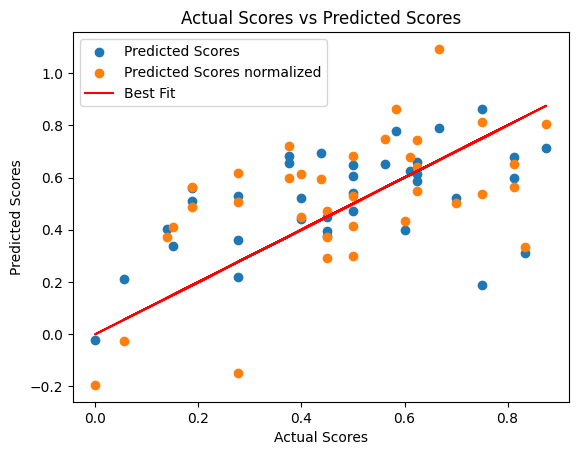

In [32]:
# Split the data into training and testing sets
X = new_df.drop(['username', 'score'], axis=1)
y = new_df['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the scores for the test set
y_pred = model.predict(X_test)

# norrmalize the features
for col in X.columns:
    X[col] = X[col].div(X[col].sum())
    # X[col] = X[col].div(new_df['total_actions'])

X = X.fillna(0)
# standardize the features
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
X = preprocessing.normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model.fit(X_train, y_train)

# Predict the scores for the test set
y_pred_norm = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R2: ', r2)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred_norm)
r2 = r2_score(y_test, y_pred_norm)
print('RMSE normalize: ', rmse)
print('R2 normalize: ', r2)


# plot the predicted and actual scores
plt.scatter(y_test, y_pred, label='Predicted Scores')
plt.scatter(y_test, y_pred_norm, label='Predicted Scores normalized')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual Scores vs Predicted Scores')
# plot the line of best fit
plt.plot(y_test, y_test, color='red', label='Best Fit')
plt.legend()
plt.show()



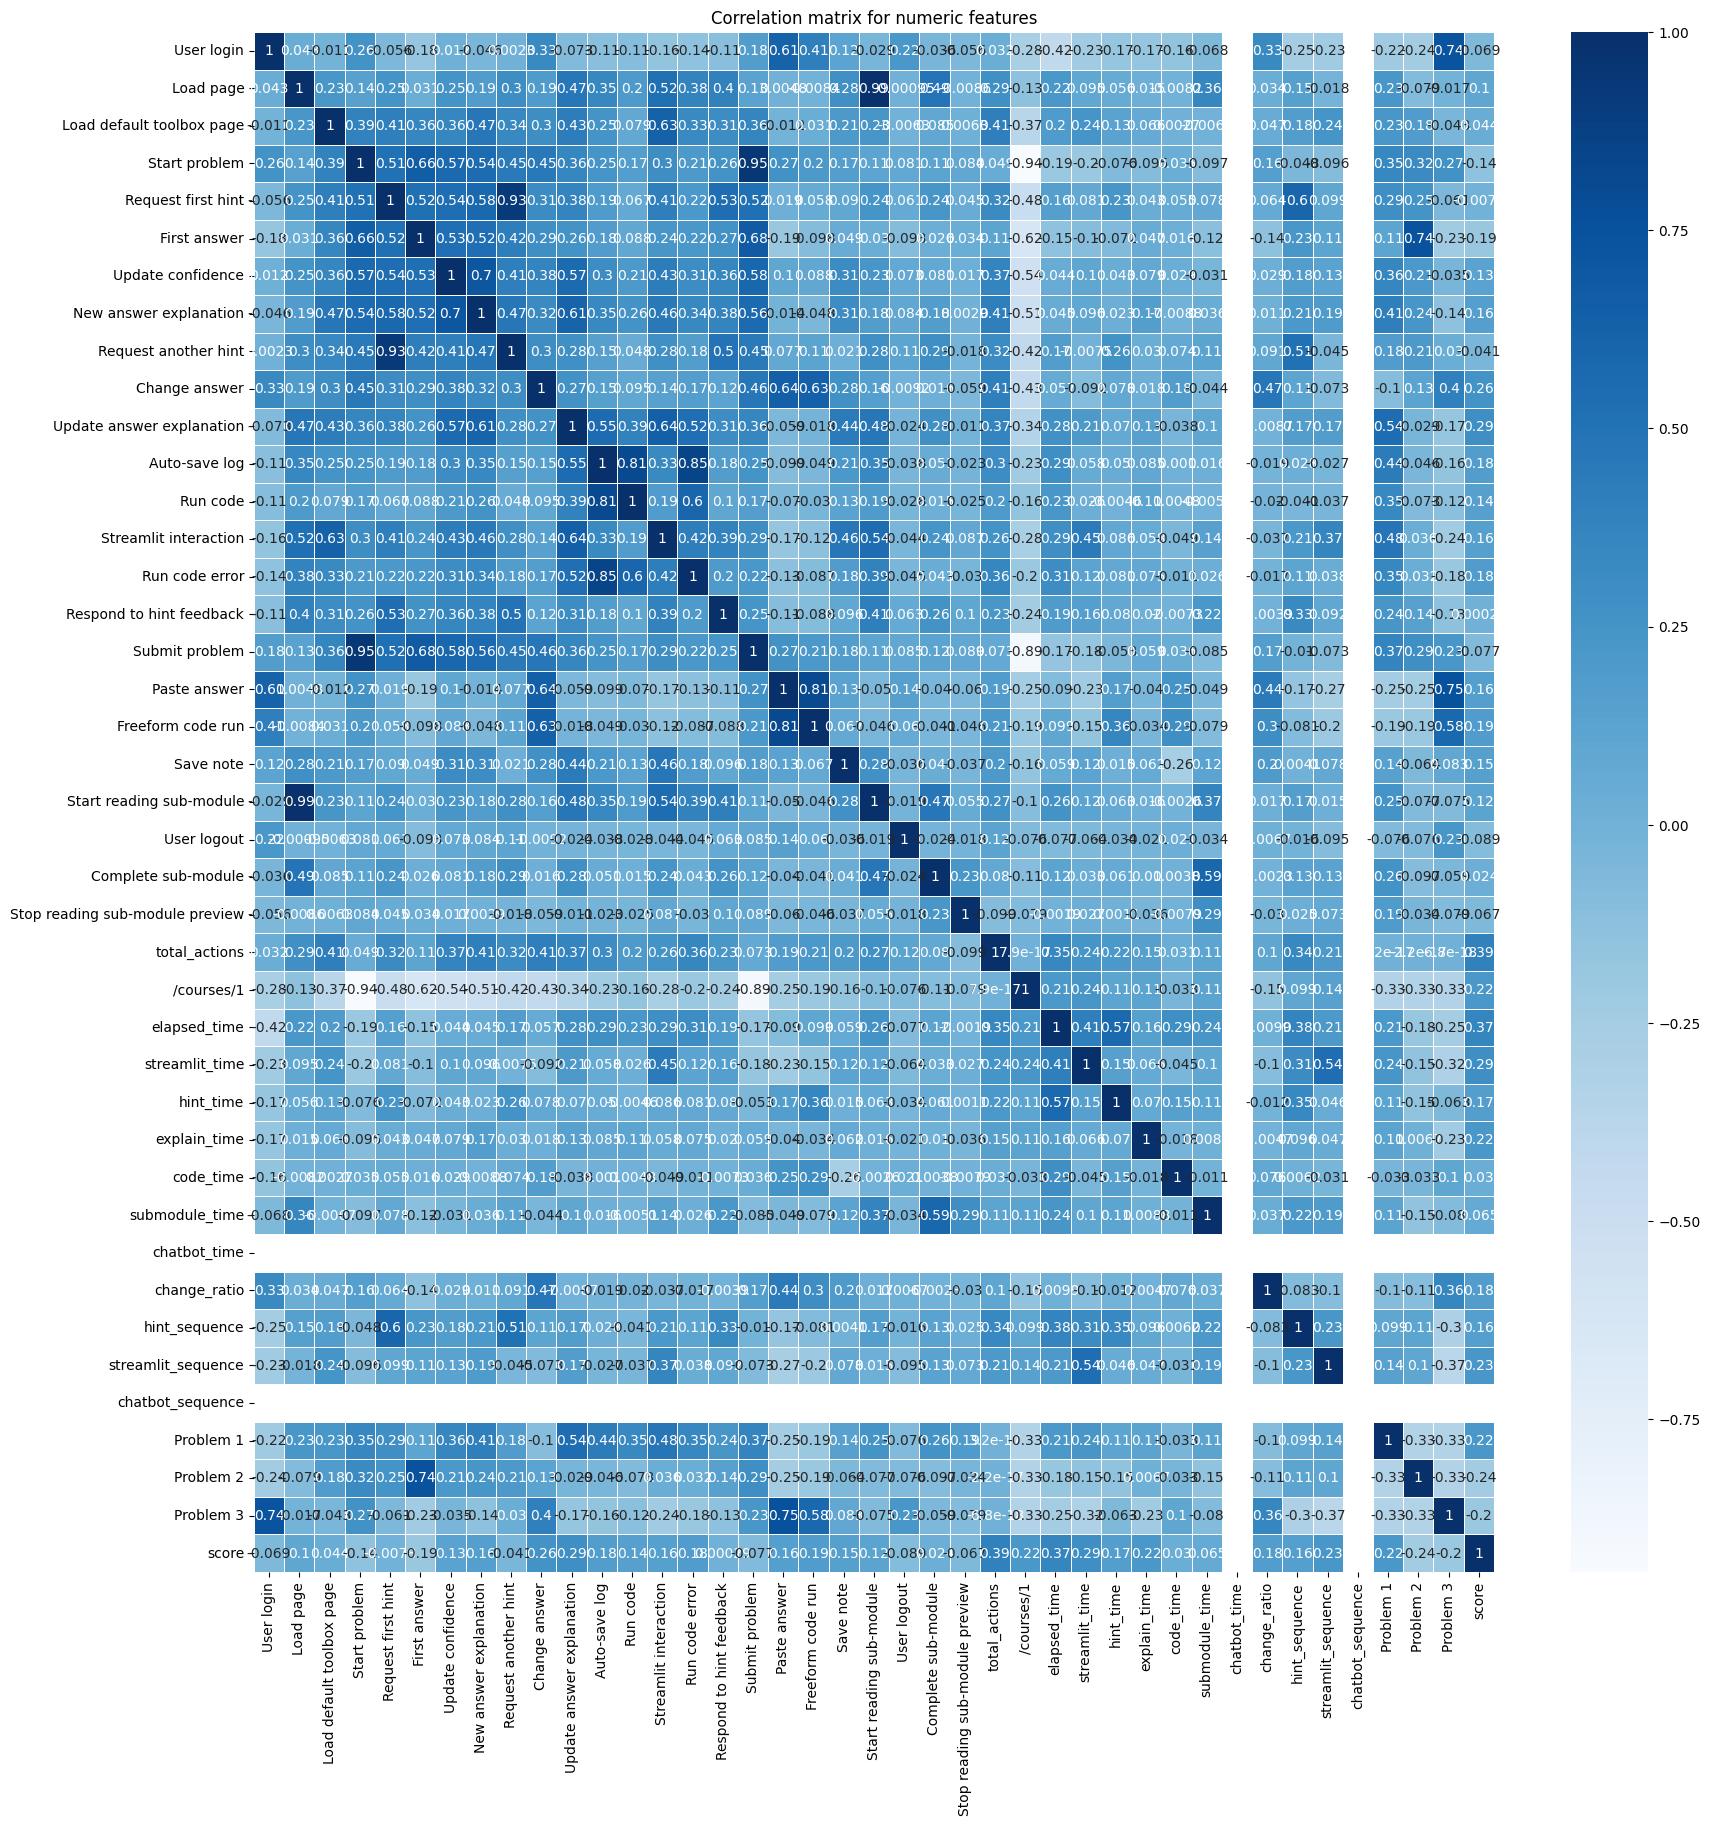

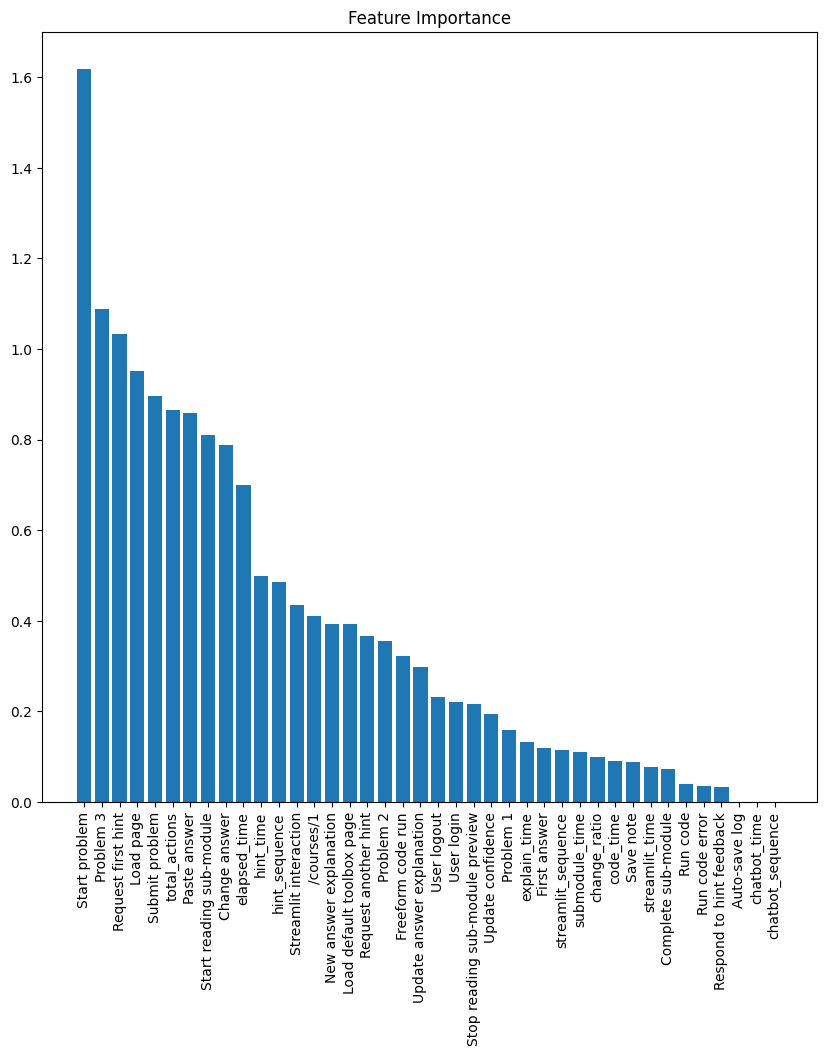

In [33]:
# Calculate the correlation coefficient matrix
correlation_matrix = new_df.drop(['username'], axis=1).corr()


plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, cmap='Blues')
plt.title('Correlation matrix for numeric features')

# convert X to dataframe
X = pd.DataFrame(X, columns=new_df.drop(['username', 'score'], axis=1).columns)

# Get the feature importance from the trained linear regression model
feature_importance = model.coef_

# Create a DataFrame to display the feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': abs(feature_importance)})


# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot the feature importance
plt.figure(figsize=(10, 10))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.show()


RMSE:  0.0868065200617284
R2:  -0.7230295107477793


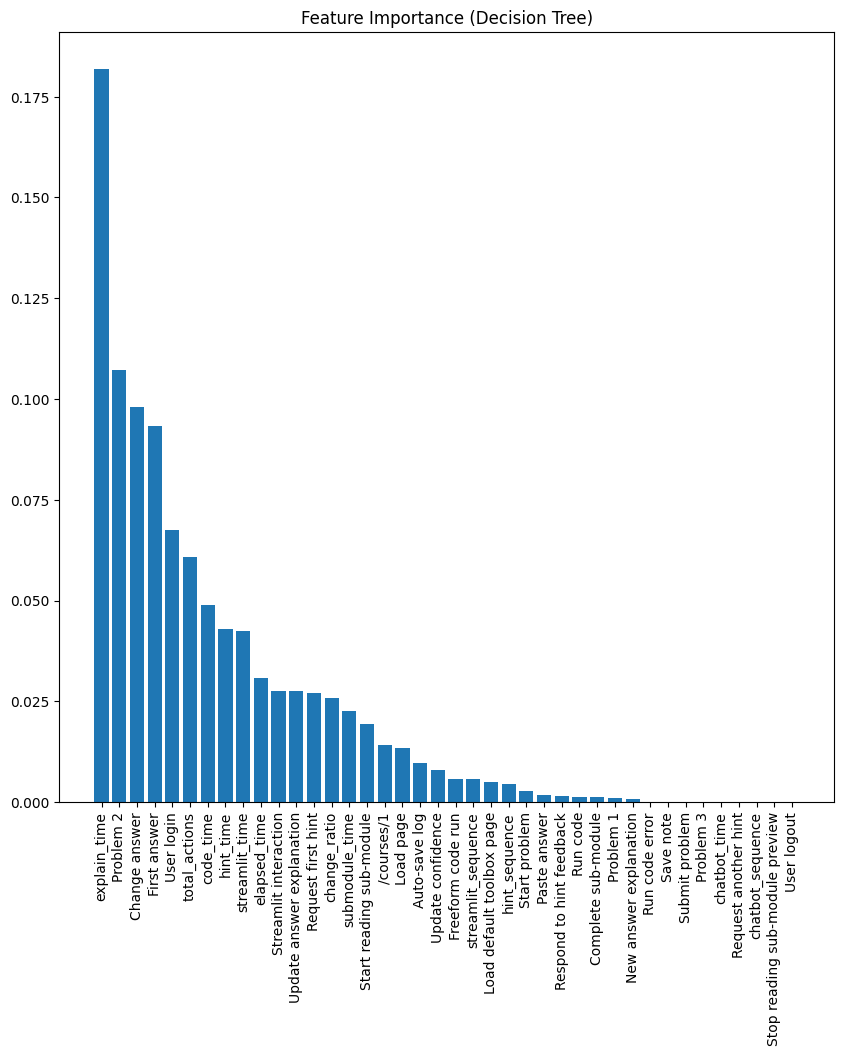

In [34]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create the decision tree regressor
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

# Predict the scores for the test set
y_pred = tree.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R2: ', r2)


# Get the feature importances from the decision tree
feature_importance_tree = tree.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_tree_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance_tree})

# Sort the DataFrame by importance in descending order
feature_importance_tree_df = feature_importance_tree_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 10))
plt.bar(feature_importance_tree_df['Feature'], feature_importance_tree_df['Importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance (Decision Tree)')
plt.show()


Best Parameters: {'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best Score: -0.09046092798546834
RMSE: 0.05469665511569258
R2: -0.0856782513170049


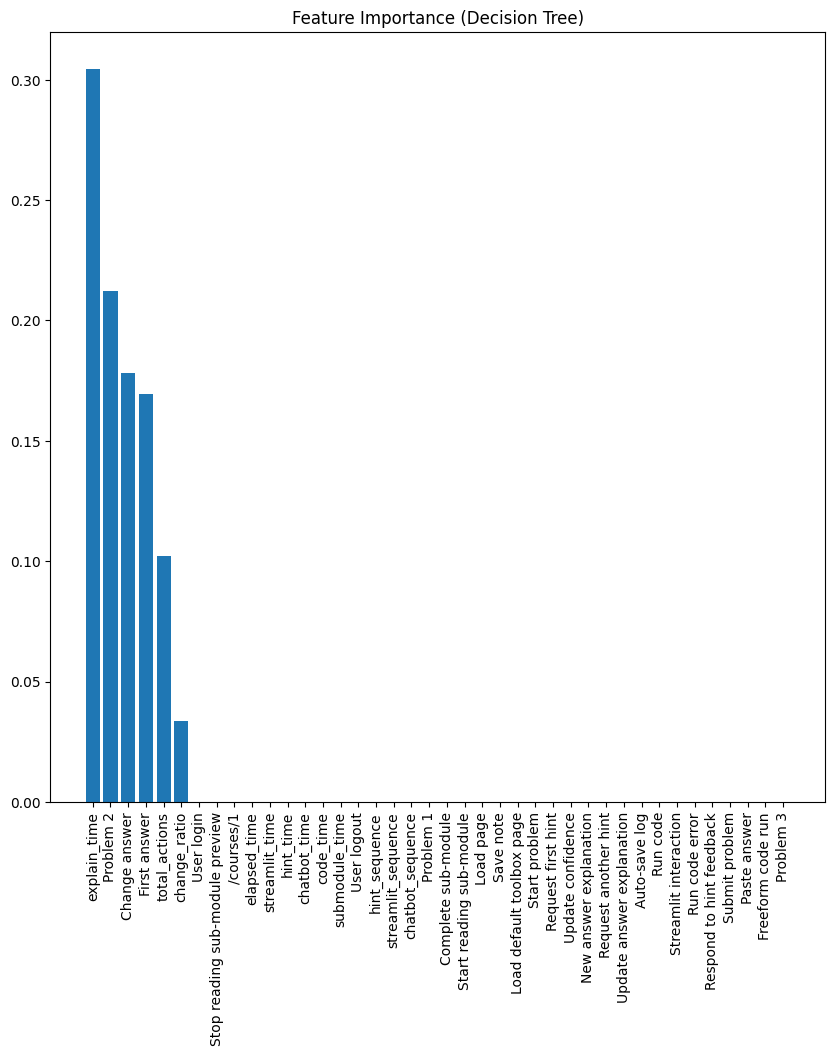

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [1, 3, 5, 7],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Create the decision tree regressor
tree = DecisionTreeRegressor(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(tree, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the decision tree with the best parameters
best_tree = DecisionTreeRegressor(random_state=42, **best_params)
best_tree.fit(X_train, y_train)

# Predict the scores for the test set
y_pred = best_tree.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Best Parameters:', best_params)
print('Best Score:', best_score)
print('RMSE:', rmse)
print('R2:', r2)


# Get the feature importances from the decision tree
feature_importance_tree = best_tree.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_tree_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance_tree})

# Sort the DataFrame by importance in descending order
feature_importance_tree_df = feature_importance_tree_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 10))
plt.bar(feature_importance_tree_df['Feature'], feature_importance_tree_df['Importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance (Decision Tree)')
plt.show()


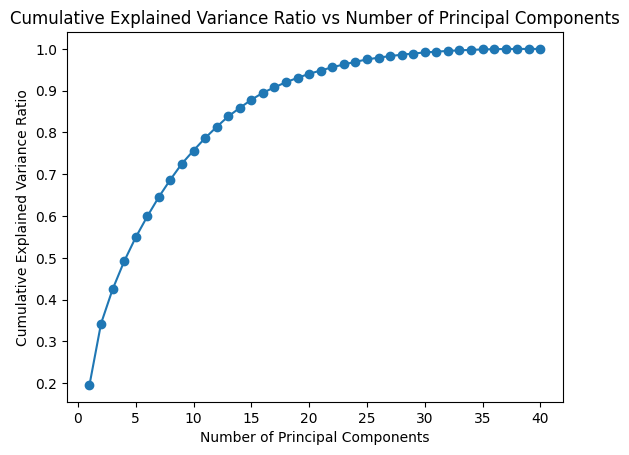

Most Important Features: Index(['User login', 'Load page', 'Load default toolbox page', 'Start problem',
       'Request first hint', 'First answer', 'Update confidence',
       'New answer explanation', 'Request another hint', 'Change answer',
       'Update answer explanation', 'Auto-save log', 'Run code',
       'Streamlit interaction', 'Run code error', 'Respond to hint feedback',
       'Submit problem', 'Paste answer', 'Freeform code run', 'Save note',
       'Start reading sub-module', 'User logout'],
      dtype='object')


In [36]:
from sklearn.decomposition import PCA
import numpy as np

# Create the PCA object
pca = PCA()

# Fit the PCA model to the training data
pca.fit(X_train)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Get the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the explained variance ratio
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs Number of Principal Components')
plt.show()

# Get the most important features based on the explained variance ratio
num_components = np.argmax(cumulative_explained_variance_ratio >= 0.95) + 1
most_important_features = X.columns[:num_components]

print('Most Important Features:', most_important_features)


RMSE:  0.038812118042192714
R2:  0.2296151865808036


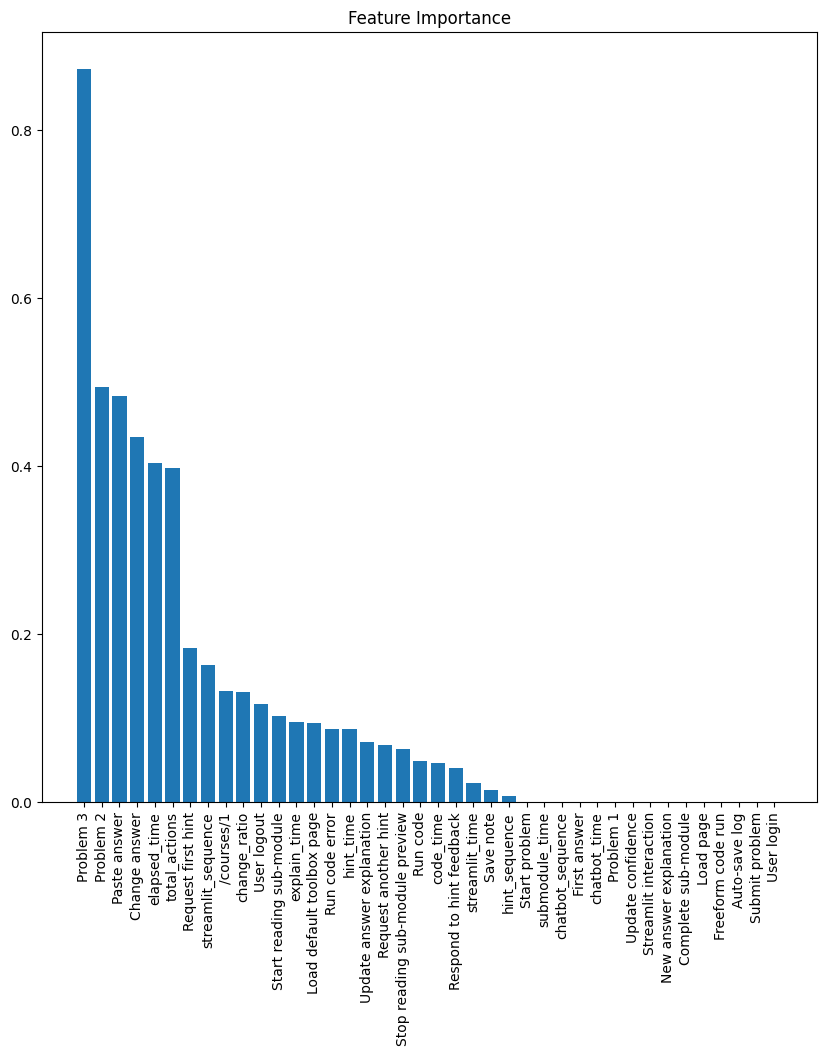

In [37]:
from sklearn.linear_model import Lasso

# Create the Lasso regression model
lasso = Lasso(alpha=0.001)

# Fit the model to the training data
lasso.fit(X_train, y_train)

# Predict the scores for the test set
y_pred = lasso.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R2: ', r2)


# Get the feature importance from the trained linear regression model
feature_importance = lasso.coef_

# Create a DataFrame to display the feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': abs(feature_importance)})


# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot the feature importance
plt.figure(figsize=(10, 10))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.show()

In [38]:
# find the index of feature_importance of value less than 1e-4
ind = []
for i in range(len(feature_importance)):
    if feature_importance[i] < 1e-4:
        ind.append(i)
# drop the colomns with index in ind
X_new = X.drop(X.columns[ind], axis=1)
# create df of X_train
X_train_new = pd.DataFrame(X_train, columns=X.columns)
X_train_new = X_train_new.drop(X_train_new.columns[ind], axis=1)

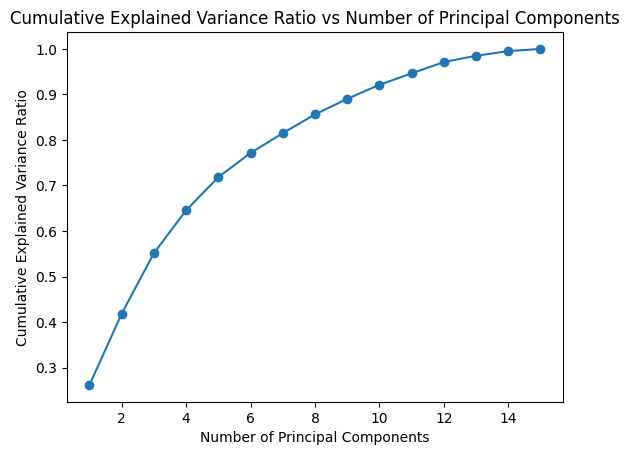

Most Important Features: Index(['Change answer', 'Update answer explanation', 'Run code',
       'Run code error', 'Paste answer', 'Save note',
       'Start reading sub-module', 'total_actions', 'elapsed_time',
       'streamlit_time', 'explain_time', 'code_time'],
      dtype='object')


In [39]:
# Fit the PCA model to the training data
pca.fit(X_train_new)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Get the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the explained variance ratio
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs Number of Principal Components')
plt.show()

# Get the most important features based on the explained variance ratio
num_components = np.argmax(cumulative_explained_variance_ratio >= 0.95) + 1
most_important_features = X_new.columns[:num_components]

print('Most Important Features:', most_important_features)

In [40]:
# remove the features that are not important

# Auto-save log                      1018
# Load default toolbox page           942
# Load page                           453
# Run code error                      276
# Start reading sub-module            135
# User login                           53
# User logout                           6
# Start problem                       124
# Submit problem                      111

new_df.drop(['Save note','Auto-save log', 'Load default toolbox page', 'Load page', 'Run code error', 'Start reading sub-module', 'User login', 'User logout',  'Start problem', 'Submit problem'], axis=1, inplace=True)


In [41]:
# compute 3 seperate models for each problem
# create 3 df for each problem and drop problem 2 and 3 from each df
df1 = new_df[new_df['Problem 1'] == 1].drop(['Problem 1', 'Problem 2', 'Problem 3'], axis=1)
df2 = new_df[new_df['Problem 2'] == 1].drop(['Problem 1', 'Problem 2', 'Problem 3'], axis=1)
df3 = new_df[new_df['Problem 3'] == 1].drop(['Problem 1', 'Problem 2', 'Problem 3'], axis=1)

In [42]:
#convert the new_df to csv
new_df.to_csv('data/all_engineered_b.csv', index=False)
df1.to_csv('data/q1_engineered_b.csv', index=False)
df2.to_csv('data/q2_engineered_b.csv', index=False)
df3.to_csv('data/q3_engineered_b.csv', index=False)